In [1]:
import torch
import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        """
        input shape: (batch_size, 1, 28, 28)
        conv1: (1, 28, 28) -> (6, 24, 24) -> (6, 12, 12)
        """
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        input shape: (batch_size, 6, 12, 12)
        conv2: (6, 12, 12) -> (16, 8, 8) -> (16, 4, 4)
        """
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        input shape: (batch_size, 16, 4, 4)
        fc1: (16, 4, 4) -> (120,)
        """
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU()
        )

        """
        input shape: (batch_size, 120)
        fc2: (120,) -> (84,)
        """
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )

        """
        input shape: (batch_size, 84)
        fc3: (84,) -> (10,)
        """
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        input shape: (batch_size, 1, 28, 28)
        """
        x = x.view(-1, 1, 28, 28)

        """
        input shape: (batch_size, 1, 28, 28)
        conv1: (1, 28, 28) -> (6, 24, 24) -> (6, 12, 12)
        """
        x = self.conv1(x)

        """
        input shape: (batch_size, 6, 12, 12)
        conv2: (6, 12, 12) -> (16, 8, 8) -> (16, 4, 4)
        """
        x = self.conv2(x)

        """
        flatten
        input shape: (batch_size, 16, 4, 4)
        output shape: (batch_size, 16*4*4)
        """
        x = x.view(x.size(0), -1)

        """
        input shape: (batch_size, 16*4*4)
        fc1: (16*4*4) -> (120,)
        """
        x = self.fc1(x)

        """
        input shape: (batch_size, 120)
        fc2: (120,) -> (84,)
        """
        x = self.fc2(x)

        """
        input shape: (batch_size, 84)
        fc3: (84,) -> (10,)
        """
        output = self.fc3(x)

        return output

    def predict(self, x):
        with torch.no_grad():
            output = self.forward(x)
            prob = torch.softmax(output, dim=1)
            prob_list = prob.squeeze().tolist()
            prob, index = torch.max(prob, 1)
        return index, prob, prob_list


def print_params(model):
    count = 0
    for name, param in model.named_parameters():
        count += param.numel()
        print(name, param.shape)
    print('total parameters:', count)


def print_forward(model, x):
    print('input x to model:', x.shape)
    for name, layer in model.named_children():
        if name == 'fc1':
            x = x.view(x.shape[0], -1)
        x = layer(x)
        print(f'{name} after size: {x.shape}')


test_model = LeNet()
print(test_model)
print('---')
print_params(test_model)

x = torch.randn(64, 1, 28, 28)
print_forward(test_model, x)

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
---
conv1.0.weight torch.Size([6, 1, 5, 5])
conv1.0.bias torch.Size([6])
conv2.0.weight torch.Size([16, 6, 5, 5])
conv2.0.bias torch.Size([16])
fc1.0.weight torch.Size([120, 256])
fc1.0.bias torch.Size([120])
fc2.0.weight torch.Size([84, 120])
fc2.0.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])
total parameters: 44426
inp

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random

# 设置全局随机种子
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)


transform = transforms.Compose([
    transforms.RandomRotation(12),  # 随机旋转 12 度
    transforms.ToTensor(),
])

# 加载训练数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)


# 定义训练数据加载器
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)


# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
import wandb
wandb.require("core")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def calculate_test_performance(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * len(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy


model = LeNet()
epochs = 2
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

model.to(device)
criterion.to(device)

total = len(train_loader.dataset)  # type: ignore

wandb_init_args = {
    'project': 'MNIST-手写数字识别',
    'config': {
        "learning_rate": learning_rate,
        "architecture": "LeNet-5",
        "dataset": "MNIST",
        "epochs": epochs,
    },
    'reinit': True
}
run = wandb.init(**wandb_init_args, job_type="training")
wandb_init_args['name'] = run.name

for epoch in range(epochs):
    train_loss = 0.0
    train_correct = 0.0

    for i, (images, labels) in enumerate(train_loader):
        model.train()
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
        train_correct += (outputs.argmax(1) == labels).sum().item()

        if (i + 1) % 100 == 0:
            print(
                f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    test_loss, test_accuracy = calculate_test_performance(
        model, test_loader, criterion)
    wandb.log({
        "train_loss": train_loss / total,
        "test_loss": test_loss,
        "train_accuracy": train_correct / total,
        "test_accuracy": test_accuracy
    })


wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wuhonglei1017368065 (wuhonglei1017368065-shopee). Use `wandb login --relogin` to force relogin


Epoch [1/2], Step [100/938], Loss: 0.6048
Epoch [1/2], Step [200/938], Loss: 0.4315
Epoch [1/2], Step [300/938], Loss: 0.2499
Epoch [1/2], Step [400/938], Loss: 0.2733
Epoch [1/2], Step [500/938], Loss: 0.1536
Epoch [1/2], Step [600/938], Loss: 0.1178
Epoch [1/2], Step [700/938], Loss: 0.2824
Epoch [1/2], Step [800/938], Loss: 0.0920
Epoch [1/2], Step [900/938], Loss: 0.1412
Epoch [2/2], Step [100/938], Loss: 0.0849
Epoch [2/2], Step [200/938], Loss: 0.0586
Epoch [2/2], Step [300/938], Loss: 0.1368
Epoch [2/2], Step [400/938], Loss: 0.2526
Epoch [2/2], Step [500/938], Loss: 0.0564
Epoch [2/2], Step [600/938], Loss: 0.1056
Epoch [2/2], Step [700/938], Loss: 0.1014
Epoch [2/2], Step [800/938], Loss: 0.0392
Epoch [2/2], Step [900/938], Loss: 0.0252


test_accuracy,▁█
test_loss,█▁
train_accuracy,▁█
train_loss,█▁
test_accuracy,0.9793
test_loss,0.06109
train_accuracy,0.9677
train_loss,0.10369


In [16]:
model = LeNet()
model.load_state_dict(torch.load(
    './model.pth', map_location=torch.device('cpu')))

/var/folders/4d/14nkpqsn4zs8c1dmkl0p4mxr0000gp/T/ipykernel_65232/703398484.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


<All keys matched successfully>

{0: 2, 1: 4, 2: 4, 3: 9, 4: 13, 5: 10, 6: 12, 7: 15, 8: 6, 9: 12}
error-count: 87
Accuracy of the network on the 10000 test images: 99.13%


<BarContainer object of 10 artists>

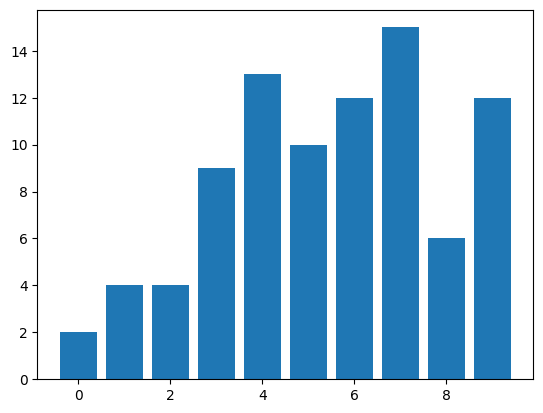

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

# 测试模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    """ 统计每个数字的错误次数 """
    error_count_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0
    }
    test_loss = 0.0
    correct = 0
    total = 0

    for batch_index, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        error_index = np.where((predicted == labels).cpu().numpy() == False)[0]
        for index in error_index:
            error_count_dict[labels[index].item()] += 1

test_loss /= total
test_accuracy = correct / total

pprint(error_count_dict)
print('error-count:', sum(error_count_dict.values()))
print('Accuracy of the network on the 10000 test images: {:.2f}%'.format(
    100 * test_accuracy))

# 将每个数字的错误次数绘制为柱状图
plt.bar(error_count_dict.keys(), error_count_dict.values())

In [15]:
# 保存后加载模型
torch.save(model.state_dict(), './model.pth')

# model = Net()
# model.load_state_dict(torch.load('./server/model.pth'))

# # 创建一个示例输入张量（假设输入尺寸是 [1, 784]）
# dummy_input = torch.randn(1, 28 * 28)

# # 导出模型到 ONNX 格式
# torch.onnx.export(
#     model,                # 要转换的模型
#     dummy_input,          # 示例输入张量
#     "model.onnx",         # 导出的 ONNX 文件名
#     input_names=['input'],  # 输入张量的名称
#     output_names=['output'],  # 输出张量的名称
#     opset_version=11      # ONNX opset 版本，通常使用最新版本（这里使用 11）
# )